# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
 -1
  1
 -1
  1
  1
  1
  1
  1
  1
 -1
  ⋮
  1
  1
  1
  1
 -1
 -1
 -1
 -1
 -1

### We create a function to visualize the data

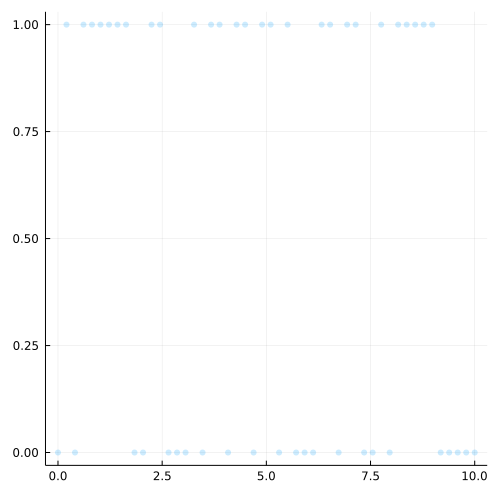

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  1.234121 seconds (1.85 M allocations: 98.292 MiB, 13.16% gc time, 99.67% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink(LogExpFunctions.logistic)) infered by Analytic Variational Inference , (local_vars = (c = [0.7622738771215215, 0.7776117103455368, 0.8291890622538981, 0.898109965792499, 0.9578195470305093, 0.9860826636391788, 0.970587809877479, 0.9112316913689352, 0.820377019329599, 0.7211999365344195  …  0.7715069893828771, 0.7496983181355837, 0.6976911870133915, 0.6352484264991347, 0.6042619455485214, 0.6465687236169626, 0.758827475311882, 0.8990871522761437, 1.0270575906122923, 1.1190343478445992], θ = [0.23855889447199793, 0.23812032696485663, 0.23659674606691608, 0.23444895751247094, 0.23249163214796514, 0.23153584327650897, 0.23206209986306303, 0.2340262534604744, 0.23686227235470203, 0.23969940618161625  …  0.23829569678322107, 0.23891338198525924, 0.2403293650585385, 0.2419188559092156, 0.24266093021723387, 0.2416399226184976, 0.23865650331152352, 0.23441762624054951, 0.2301185961079

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:05:06
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:35
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:43
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:17
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:01
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:51
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:44
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:38
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:34
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:30
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:27
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:25
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[0.4936253718197826, 0.4250631445261953, 0.3639489051364226, 0.3067985420763381, 0.256974819935802, 0.18801811476721753, 0.13457232675405184, 0.041136338268633055, -0.028229857681352444, -0.08740200746262067  …  0.3879549189840479, 0.40452275648415975, 0.3679836647855737, 0.16832519150355346, -0.10513192839402996, -0.41929058425846477, -0.6720920410302977, -0.84044541785097, -0.8908326999266025, -0.8554633096952534]]
 [[-0.22442498931974766, -0.12184758615816121, -0.13184575697729867, -0.12294588747858226, -0.17330240533063412, -0.23780104528599866, -0.3166464806636997, -0.37622342913988394, -0.37354494073553424, -0.36491388760256704  …  0.15165263558353834, 0.0862562891082419, -0.06504495335174909, -0.29638219725771214, -0.5869284117755547, -0.8929878761602704, -1.2232763712660257, -1.5159805782718827, -1.7218709841092612, -1.8291789065394852]]
 [[-1.2453220394043591, -0.9130030638851778, -0.48891781803049517, -0.05109348834283711, 0.336

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

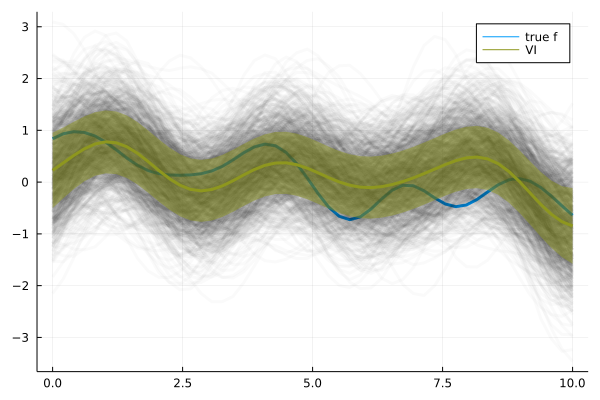

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

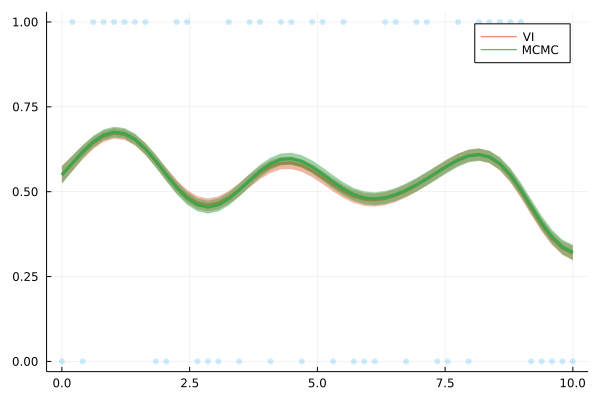

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*